In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from tqdm import tqdm
%matplotlib inline
from torch.utils.data import Dataset, DataLoader
import torch
import torchvision

import torch.nn as nn
import torch.optim as optim
from torch.nn import functional as F
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cpu


# Generate dataset

In [2]:
y = np.random.randint(0,4,1200)
idx= []
for i in range(4):
    #print(i,sum(y==i))
    idx.append(y==i)

In [3]:
x = np.zeros((1200,2))

In [4]:


x[idx[0],:] = np.random.uniform(low=[5,2],high=[6,4],size=(sum(idx[0]),2))

x[idx[1],:] = np.random.uniform(low=[5,-3],high=[6,-5],size=(sum(idx[1]),2))

x[idx[2],:] = np.random.uniform(low=[8,0],high=[9,-2],size=(sum(idx[2]),2))

x[idx[3],:] = np.random.uniform(low=[1,-1],high=[2,5],size=(sum(idx[3]),2))

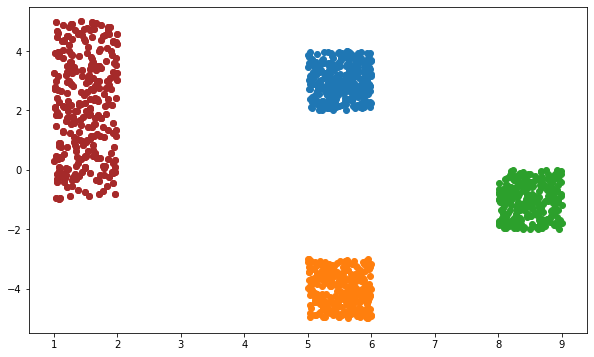

In [5]:
plt.figure(figsize=(10,6))
for i in range(4):
    plt.scatter(x[idx[i],0],x[idx[i],1],label="class_"+str(i))
    if i ==3:
      plt.scatter(x[idx[i],0],x[idx[i],1],label="class_"+str(i),c=["brown"])

#plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.savefig("dist_1.png",bbox_inches="tight")
plt.savefig("dist_1.pdf",bbox_inches="tight")


In [6]:
foreground_classes = {'class_0','class_1', 'class_2'}

background_classes = {'class_3'}

In [7]:
desired_num = 3000
mosaic_list =[]
mosaic_label = []
fore_idx=[]
for j in range(desired_num):
    fg_class  = np.random.randint(0,3)
    fg_idx = np.random.randint(0,9) #m=9
    a = []
    for i in range(9):  #m=9
        if i == fg_idx:
            b = np.random.choice(np.where(idx[fg_class]==True)[0],size=1)
            a.append(x[b])
#             print("foreground "+str(fg_class)+" present at " + str(fg_idx))
        else:
            bg_class = np.random.randint(3,4)
            b = np.random.choice(np.where(idx[bg_class]==True)[0],size=1)
            a.append(x[b])
#             print("background "+str(bg_class)+" present at " + str(i))
    a = np.concatenate(a,axis=0)
    mosaic_list.append(np.reshape(a,(18,1)))
    mosaic_label.append(fg_class)
    fore_idx.append(fg_idx)

In [8]:
mosaic_list = np.concatenate(mosaic_list,axis=1).T
# print(mosaic_list)

In [9]:
class MosaicDataset(Dataset):
  """MosaicDataset dataset."""

  def __init__(self, mosaic_list, mosaic_label, fore_idx):
    """
      Args:
        csv_file (string): Path to the csv file with annotations.
        root_dir (string): Directory with all the images.
        transform (callable, optional): Optional transform to be applied
            on a sample.
    """
    self.mosaic = mosaic_list
    self.label = mosaic_label
    self.fore_idx = fore_idx

  def __len__(self):
    return len(self.label)

  def __getitem__(self, idx):
    return self.mosaic[idx] , self.label[idx], self.fore_idx[idx]

batch = 250
msd = MosaicDataset(mosaic_list, mosaic_label , fore_idx)
train_loader = DataLoader( msd,batch_size= batch ,shuffle=True)

In [10]:
class Wherenet(nn.Module):
    def __init__(self):
        super(Wherenet,self).__init__()
        self.linear1 = nn.Linear(2,1)

    def forward(self,z):
        x = torch.zeros([batch,9],dtype=torch.float64)  #m=2
        y = torch.zeros([batch,2], dtype=torch.float64)
        #x,y = x.to("cuda"),y.to("cuda")
        for i in range(9):  #m=9
          x[:,i] = self.helper(z[:,2*i:2*i+2])[:,0]
            #print(k[:,0].shape,x[:,i].shape)
        x = F.softmax(x,dim=1)   # alphas
        x1 = x[:,0]
        for i in range(9): #m=9
            x1 = x[:,i]          
            #print()
            y = y+torch.mul(x1[:,None],z[:,2*i:2*i+2])
        return y , x 

    
    def helper(self,x):
        #x = F.relu(self.linear1(x))
        #x = F.relu(self.linear2(x))
        x = self.linear1(x)
        return x

    

In [11]:
torch.manual_seed(1238)
where = Wherenet().double()

In [12]:
class Whatnet(nn.Module):
    def __init__(self):
        super(Whatnet,self).__init__()
        self.linear1 = nn.Linear(2,3)
        #self.linear2 = nn.Linear(4,3)
#         self.linear3 = nn.Linear(8,3)
    def forward(self,x):
        #x = F.relu(self.linear1(x))
        #x = F.relu(self.linear2(x))
        x = self.linear1(x)
        return x

In [13]:
torch.manual_seed(1238)
what = Whatnet().double()
# what(out_where)

In [14]:
test_data_required = 1000
mosaic_list_test =[]
mosaic_label_test = []
fore_idx_test=[]
for j in range(test_data_required):
    fg_class  = np.random.randint(0,3)
    fg_idx = np.random.randint(0,9)  #m=9
    a = []
    for i in range(9): #m=9
        if i == fg_idx:
            b = np.random.choice(np.where(idx[fg_class]==True)[0],size=1)
            a.append(x[b])
#             print("foreground "+str(fg_class)+" present at " + str(fg_idx))
        else:
            bg_class = np.random.randint(3,4)
            b = np.random.choice(np.where(idx[bg_class]==True)[0],size=1)
            a.append(x[b])
#             print("background "+str(bg_class)+" present at " + str(i))
    a = np.concatenate(a,axis=0)
    mosaic_list_test.append(np.reshape(a,(18,1)))
    mosaic_label_test.append(fg_class)
    fore_idx_test.append(fg_idx)

In [15]:
mosaic_list_test = np.concatenate(mosaic_list_test,axis=1).T
#print(mosaic_list_test.shape)

In [16]:
test_data = MosaicDataset(mosaic_list_test,mosaic_label_test,fore_idx_test)
test_loader = DataLoader( test_data,batch_size= batch ,shuffle=False)

In [ ]:

focus_true_pred_true =0
focus_false_pred_true =0
focus_true_pred_false =0
focus_false_pred_false =0

argmax_more_than_half = 0
argmax_less_than_half =0

col1=[]
col2=[]
col3=[]
col4=[]
col5=[]
col6=[]
col7=[]
col8=[]
col9=[]
col10=[]
col11=[]
col12=[]
col13=[]

criterion = nn.CrossEntropyLoss()
optimizer_where = optim.SGD(where.parameters(), lr=0.01, momentum=0.9)
optimizer_what = optim.SGD(what.parameters(), lr=0.01, momentum=0.9)

nos_epochs = 100

train_loss=[]
test_loss =[]
train_acc = []
test_acc = []
for epoch in range(nos_epochs):  # loop over the dataset multiple times

    focus_true_pred_true =0
    focus_false_pred_true =0
    focus_true_pred_false =0
    focus_false_pred_false =0

    argmax_more_than_half = 0
    argmax_less_than_half =0

    running_loss = 0.0
    cnt=0

    iteration = desired_num // batch

    #training data set

    for i, data in  enumerate(train_loader):
        inputs , labels , fore_idx = data
        #inputs,labels,fore_idx = inputs.to(device),labels.to(device),fore_idx.to(device)
        # zero the parameter gradients

        optimizer_what.zero_grad()
        optimizer_where.zero_grad()
        
        
        avg_inp,alphas = where(inputs)
        
        outputs = what(avg_inp)
        
        _, predicted = torch.max(outputs.data, 1)
        
        loss = criterion(outputs, labels) 
        loss.backward() 
        
        optimizer_what.step()
        optimizer_where.step() 
        

        running_loss += loss.item()
        if cnt % 6 == 5:    # print every 6 mini-batches
            print('[%d, %5d] loss: %.3f' %(epoch + 1, cnt + 1, running_loss / 6))
            running_loss = 0.0
        cnt=cnt+1
    
        if epoch % 5 == 4:
            for j in range (batch):
                focus = torch.argmax(alphas[j])

                if(alphas[j][focus] >= 0.5):
                    argmax_more_than_half +=1
                else:
                    argmax_less_than_half +=1

                if(focus == fore_idx[j] and predicted[j] == labels[j]):
                    focus_true_pred_true += 1

                elif(focus != fore_idx[j] and predicted[j] == labels[j]):
                    focus_false_pred_true +=1

                elif(focus == fore_idx[j] and predicted[j] != labels[j]):
                    focus_true_pred_false +=1

                elif(focus != fore_idx[j] and predicted[j] != labels[j]):
                    focus_false_pred_false +=1

    if epoch % 5 == 4:
        col1.append(epoch)
        col2.append(argmax_more_than_half)
        col3.append(argmax_less_than_half)
        col4.append(focus_true_pred_true)
        col5.append(focus_false_pred_true)
        col6.append(focus_true_pred_false)
        col7.append(focus_false_pred_false)

    #************************************************************************
        #testing data set  
        with torch.no_grad():
            focus_true_pred_true =0
            focus_false_pred_true =0
            focus_true_pred_false =0
            focus_false_pred_false =0

            argmax_more_than_half = 0
            argmax_less_than_half =0
            for data in test_loader:
                inputs, labels , fore_idx = data
                #inputs,labels,fore_idx = inputs.to(device),labels.to(device),fore_idx.to(device) 
#                 print(inputs.shtorch.save(where.state_dict(),"model_epoch"+str(epoch)+".pt")ape,labels.shape)
                avg_inp,alphas = where(inputs)
                outputs = what(avg_inp)
                _, predicted = torch.max(outputs.data, 1)

                for j in range (batch):
                    focus = torch.argmax(alphas[j])

                    if(alphas[j][focus] >= 0.5):
                        argmax_more_than_half +=1
                    else:
                        argmax_less_than_half +=1

                    if(focus == fore_idx[j] and predicted[j] == labels[j]):
                        focus_true_pred_true += 1

                    elif(focus != fore_idx[j] and predicted[j] == labels[j]):
                        focus_false_pred_true +=1

                    elif(focus == fore_idx[j] and predicted[j] != labels[j]):
                        focus_true_pred_false +=1

                    elif(focus != fore_idx[j] and predicted[j] != labels[j]):
                        focus_false_pred_false +=1

        col8.append(argmax_more_than_half)
        col9.append(argmax_less_than_half)
        col10.append(focus_true_pred_true)
        col11.append(focus_false_pred_true)
        col12.append(focus_true_pred_false)
        col13.append(focus_false_pred_false)
        
        #torch.save(where.state_dict(),"where_model_epoch"+str(epoch)+".pt")
        #torch.save(what.state_dict(),"what_model_epoch"+str(epoch)+".pt")
    
print('Finished Training')
#torch.save(where.state_dict(),"where_model_epoch"+str(nos_epochs)+".pt")
#torch.save(what.state_dict(),"what_model_epoch"+str(epoch)+".pt")


In [18]:
columns = ["epochs", "argmax > 0.5" ,"argmax < 0.5", "focus_true_pred_true", "focus_false_pred_true", "focus_true_pred_false", "focus_false_pred_false" ]
df_train = pd.DataFrame()
df_test = pd.DataFrame()
df_train[columns[0]] = col1
df_train[columns[1]] = col2
df_train[columns[2]] = col3
df_train[columns[3]] = col4
df_train[columns[4]] = col5
df_train[columns[5]] = col6
df_train[columns[6]] = col7

df_test[columns[0]] = col1
df_test[columns[1]] = col8
df_test[columns[2]] = col9
df_test[columns[3]] = col10
df_test[columns[4]] = col11
df_test[columns[5]] = col12
df_test[columns[6]] = col13

In [19]:
df_train

,epochs,argmax > 0.5,argmax < 0.5,focus_true_pred_true,focus_false_pred_true,focus_true_pred_false,focus_false_pred_false
0,4,686,2314,898,1104,171,827
1,9,2398,602,2022,968,0,10
2,14,2534,466,2022,970,0,8
3,19,2580,420,2022,971,0,7
4,24,2615,385,2022,972,0,6
5,29,2644,356,2022,973,0,5
6,34,2657,343,2022,973,0,5
7,39,2668,332,2022,973,0,5
8,44,2684,316,2022,974,0,4
9,49,2697,303,2022,974,0,4


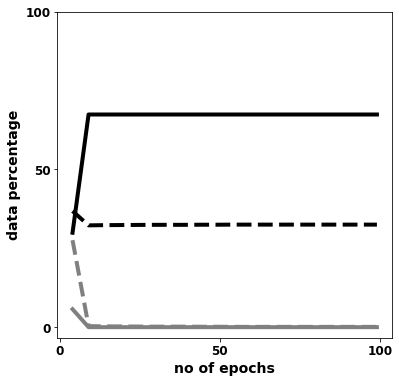

In [20]:
# plt.plot(col1,col2, label='argmax > 0.5')
# plt.plot(col1,col3, label='argmax < 0.5')

# plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
# plt.xlabel("epochs")
# plt.ylabel("training data")
# plt.title("On Training set")
# plt.show()
plt.figure(figsize=(6,6))
plt.plot(col1,np.array(col4)/30, label ="focus_true_pred_true ",linewidth=4,linestyle="-",color="black")
plt.plot(col1,np.array(col5)/30, label ="focus_false_pred_true ",linewidth=4,linestyle="--",color="black")
plt.plot(col1,np.array(col6)/30, label ="focus_true_pred_false ",linewidth=4,linestyle="-",color="grey")
plt.plot(col1,np.array(col7)/30, label ="focus_false_pred_false ",linewidth=4,linestyle="--",color="grey")
#plt.title("On Training set")
#plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.xlabel("no of epochs",fontsize=14,fontweight="bold")
plt.ylabel("data percentage",fontsize=14,fontweight="bold")
plt.xticks([0,50,100],fontsize=12,fontweight="bold")
plt.yticks([0,50,100],fontsize=12,fontweight="bold")
plt.savefig("dist_1_train.png",bbox_inches="tight")
plt.savefig("dist_1_train.pdf",bbox_inches="tight")
plt.show()

In [21]:
df_test

,epochs,argmax > 0.5,argmax < 0.5,focus_true_pred_true,focus_false_pred_true,focus_true_pred_false,focus_false_pred_false
0,4,331,669,313,348,85,254
1,9,800,200,678,315,1,6
2,14,846,154,678,316,0,6
3,19,862,138,678,316,0,6
4,24,872,128,678,317,0,5
5,29,875,125,678,317,0,5
6,34,880,120,678,317,0,5
7,39,885,115,678,317,0,5
8,44,888,112,678,317,0,5
9,49,891,109,678,317,0,5


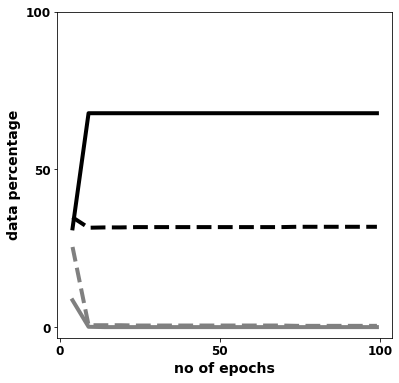

In [22]:
plt.figure(figsize=(6,6))
plt.plot(col1,np.array(col10)/10, label ="focus_true_pred_true ",linewidth=4,linestyle="-",color="black")
plt.plot(col1,np.array(col11)/10, label ="focus_false_pred_true ",linewidth=4,linestyle="--",color="black")
plt.plot(col1,np.array(col12)/10, label ="focus_true_pred_false ",linewidth=4,linestyle="-",color="grey")
plt.plot(col1,np.array(col13)/10, label ="focus_false_pred_false ",linewidth=4,linestyle="--",color="grey")
#plt.title("On Training set")
#plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.xlabel("no of epochs",fontsize=14,fontweight="bold")
plt.ylabel("data percentage",fontsize=14,fontweight="bold")
plt.xticks([0,50,100],fontsize=12,fontweight="bold")
plt.yticks([0,50,100],fontsize=12,fontweight="bold")
plt.savefig("dist_1_test.png",bbox_inches="tight")
plt.savefig("dist_1_test.pdf",bbox_inches="tight")
plt.show()

In [23]:
xx,yy= np.meshgrid(np.arange(0,10,0.05),np.arange(-6,6,0.05))
X = np.concatenate((xx.reshape(-1,1),yy.reshape(-1,1)),axis=1)
X = torch.Tensor(X).double()
Y = where.helper(X)
Y1 = what(X)

In [24]:
X = X.detach().numpy()
Y = Y[:,0].detach().numpy()

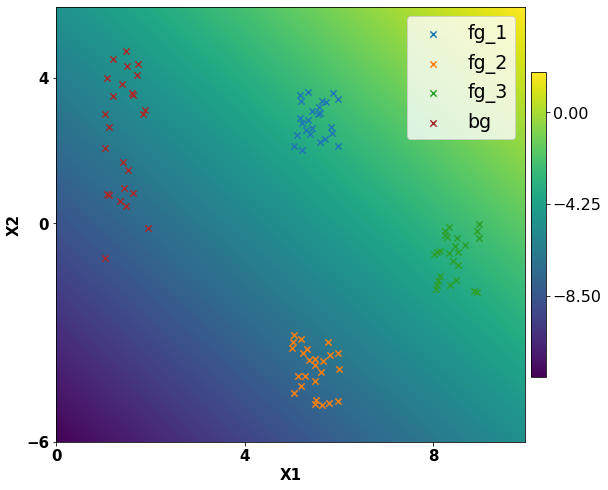

In [25]:
fig = plt.figure(figsize=(10,8))
cs = plt.contourf(X[:,0].reshape(xx.shape),X[:,1].reshape(yy.shape),Y.reshape(xx.shape),levels=1000)
plt.xlabel("X1",fontsize=15,fontweight="bold")
plt.ylabel("X2",fontsize=15,fontweight="bold")
cbar = fig.colorbar(cs,shrink=0.7,pad=0.01)
cbar.ax.locator_params(nbins=4)
for t in cbar.ax.get_yticklabels():
  t.set_fontsize(16)
for i in range(4):
    if i<3:
      plt.scatter(x[idx[i],0][:25],x[idx[i],1][:25],label="fg_"+str(i+1),s=40,marker="x")
    else:
      plt.scatter(x[idx[i],0][:25],x[idx[i],1][:25],label="bg",c="brown",s=40,marker="x")

plt.legend(loc='upper right',fontsize="19")#, bbox_to_anchor=(1, 0.5))
plt.xticks([0,4,8],fontsize=15,fontweight="bold")
plt.yticks([-6,0,4],fontsize=15,fontweight="bold")
plt.savefig("dist_1_fc.png")#,bbox_inches='tight')
plt.savefig("dist_1_fc.pdf")#,bbox_inches='tight')


In [26]:
Y1 = Y1.detach().numpy()
Y1 = torch.softmax(torch.Tensor(Y1),dim=1)
_,Z4= torch.max(Y1,1)
Z1 = Y1[:,0]
Z2 = Y1[:,1]
Z3 = Y1[:,2]

In [27]:
avrg = []
lbl = []
with torch.no_grad():
  for i, data in  enumerate(train_loader):
          inputs , labels , fore_idx = data
          avg_inp,alphas = where(inputs)
          avrg.append(avg_inp)
          lbl.append(labels.numpy())
avrg = np.concatenate(avrg,axis=0)
lbl = np.concatenate(lbl,axis=0)

In [28]:
indices = []
for i in range(3):
    #print(i,sum(lbl==i))
    indices.append(lbl==i)

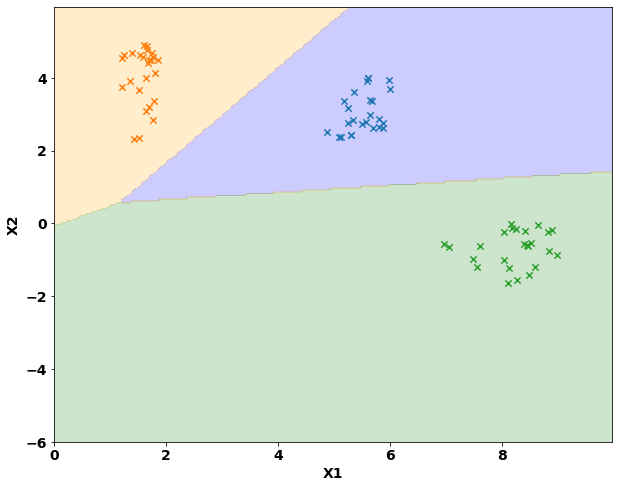

In [29]:
plt.figure(figsize=(10,8))
cs = plt.contourf(X[:,0].reshape(xx.shape),X[:,1].reshape(yy.shape),Z4.reshape(xx.shape),alpha=0.2,levels=2,colors=["blue","orange","green"])

for i in range(3):
    plt.scatter(avrg[indices[i],0][:25],avrg[indices[i],1][:25],label="fg_"+str(i),s=40,marker="x")
plt.xlabel("X1",fontsize=14,fontweight="bold")
plt.ylabel("X2",fontsize=14,fontweight="bold")
plt.xticks([0,2,4,6,8],fontsize=14,fontweight="bold")
plt.yticks([-6,-4,-2,0,2,4],fontsize=14,fontweight="bold")

plt.savefig("dist_1_db.png",bbox_inches="tight")
plt.savefig("dist_1_db.pdf",bbox_inches="tight")

In [30]:
true = []
pred = []
acc= 0
for i, data in  enumerate(train_loader):
        inputs , labels , fore_idx = data
        avg_inp,alphas = where(inputs)
        outputs = what(avg_inp)
        _, predicted = torch.max(outputs.data, 1)
        true.append(labels)
        pred.append(predicted)
        acc+=sum(predicted == labels)

In [31]:
true = np.concatenate(true,axis=0)
pred = np.concatenate(pred,axis=0)

In [32]:
from sklearn.metrics import confusion_matrix
confusion_matrix(true,pred)

array([[1005,    0,    0],
       [   3,  975,    0],
       [   0,    0, 1017]])